In [2]:
#Diretives 
AUDIO_PATH = 'test_wav/'
OUT_PATH = 'test_out/'
SH_FILE = 'goTests.sh'
SEG_SUFFIX = '.3.h.seg'

In [4]:
import numpy as np
import pandas as pd
import os
import re
import copy
import subprocess
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline  
import matplotlib

In [11]:
#calculate duration of the audio
def audio_duration(y,sr):
    return len(y)/sr
#get the number of frames
def get_nFrames(y,sr,winStep=0.010 ):
    num_frames = int(len(y)/(winStep*sr)) - 1    
    return num_frames
def Sample2sec(sample, sr):
    return sample/sr
def Sec2sample(sec, sr):
    return int(sec*sr)
def Frame2sec(frame, nframes, duration):
    return (frame*duration)/nframes
def Sec2Frame(sec, nframes, duration):
    return int((sec*nframes)/duration)
def findClusterPosition(diarfile):
    cluster_idx = []
    for i in range(len(diarfile)):
        aux_line = diarfile[i]
        if len([m.start() for m in re.finditer(';;', diarfile[i])])>0:
            cluster_idx.append(i)
    nclusters = len(cluster_idx)
    return cluster_idx, nclusters
def FindSegments_Frame(diarfile, cluster_idx, nclusters):
    ClusterSegs = []
    for i in range(nclusters):
        if(i<(nclusters-1)):
            segsClus_i = diarfile[cluster_idx[i]+1:cluster_idx[i+1]]
        else:
            segsClus_i = diarfile[cluster_idx[i]+1:]
        SegsCluster_j = []
        for j in range(len(segsClus_i)):
            seg_j = segsClus_i[j]
            spaces = [m.start() for m in re.finditer(' ', seg_j)]
            fr_start = int(seg_j[(spaces[1]+1):spaces[2]])
            fr_end = int(seg_j[(spaces[2]+1):spaces[3]]) + fr_start
            SegsCluster_j.append([fr_start, fr_end])
        ClusterSegs.append(SegsCluster_j)
    return ClusterSegs
def FindSegments_Secs(Segments_Frame, nframes, duration):
    ClusterSegs = copy.deepcopy(Segments_Frame)
    for cluster_id,i in enumerate(Segments_Frame):
        for seg_id,j in enumerate(i):
            ClusterSegs[cluster_id][seg_id][0] = Frame2sec(j[0], nframes, duration)
            ClusterSegs[cluster_id][seg_id][1] = Frame2sec(j[1], nframes, duration)
    return ClusterSegs

In [6]:
#read an audio file for experiments
sr,y = wav.read(filename='inputfolderTeste/4694.wav')

In [9]:
#filename = 'test_out/diarizationExample2/diarizationExample2.h.3.seg'
filename = 'outFolderTeste/4694/4694.d.3.seg'
with open(filename) as f:
    diarfile = f.readlines()

In [14]:
Segments_Frame = []
duration = audio_duration(y,sr)
nframes = get_nFrames(y,sr,winStep=0.010)
cluster_idx, nclusters = findClusterPosition(diarfile)
Segments_Frame = FindSegments_Frame(diarfile, cluster_idx, nclusters)
Segments_Sec = FindSegments_Secs(Segments_Frame, nframes, duration)
Segments_Sec

[[[0.0, 45.522439034191756],
  [79.31424955627742, 105.3156426777402],
  [120.26644372258129, 156.44838230467832],
  [175.3993976758983, 203.28089153075916],
  [225.482081042162, 295.4958322896085]],
 [[45.522439034191756, 79.31424955627742],
  [105.3156426777402, 120.26644372258129],
  [156.44838230467832, 175.3993976758983],
  [203.28089153075916, 225.482081042162],
  [295.4958322896085, 298.626]]]

In [16]:
#create fake reference
Segments_Ref = copy.deepcopy(Segments_Sec)
for idx1,i in enumerate(Segments_Ref):
    for idx2,j in enumerate(i):
        Segments_Ref[idx1][idx2][0] = j[0]+0.672
        Segments_Ref[idx1][idx2][1] = j[1]+0.887

In [17]:
Segments_Ref

[[[0.672, 46.409439034191756],
  [79.98624955627741, 106.2026426777402],
  [120.93844372258128, 157.33538230467832],
  [176.0713976758983, 204.16789153075916],
  [226.154081042162, 296.3828322896085]],
 [[46.19443903419175, 80.20124955627742],
  [105.9876426777402, 121.15344372258129],
  [157.12038230467832, 176.28639767589831],
  [203.95289153075916, 226.369081042162],
  [296.1678322896085, 299.513]]]

In [18]:
Segments_Sec

[[[0.0, 45.522439034191756],
  [79.31424955627742, 105.3156426777402],
  [120.26644372258129, 156.44838230467832],
  [175.3993976758983, 203.28089153075916],
  [225.482081042162, 295.4958322896085]],
 [[45.522439034191756, 79.31424955627742],
  [105.3156426777402, 120.26644372258129],
  [156.44838230467832, 175.3993976758983],
  [203.28089153075916, 225.482081042162],
  [295.4958322896085, 298.626]]]

In [19]:
#use pyannote to create the segments
%pylab inline
from pyannote.core import Annotation, Segment

Populating the interactive namespace from numpy and matplotlib


/home/jmnt/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [20]:
reference = Annotation()
for idx1,i in enumerate(Segments_Ref):
    for idx2,j in enumerate(i):
        reference[Segment(j[0], j[1])] = str(idx1)    

In [21]:
hypothesis_lium = Annotation()
for idx1,i in enumerate(Segments_Sec):
    for idx2,j in enumerate(i):
        hypothesis_lium[Segment(j[0], j[1])] = str(idx1)   

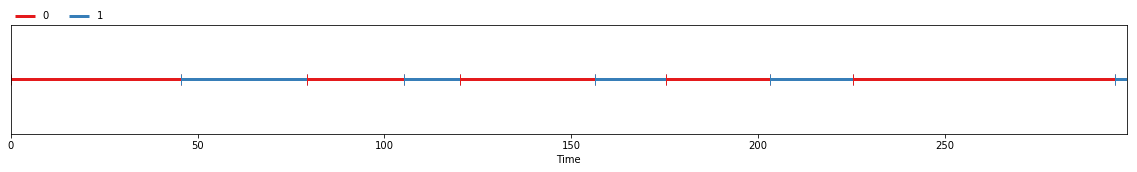

In [22]:
hypothesis_lium

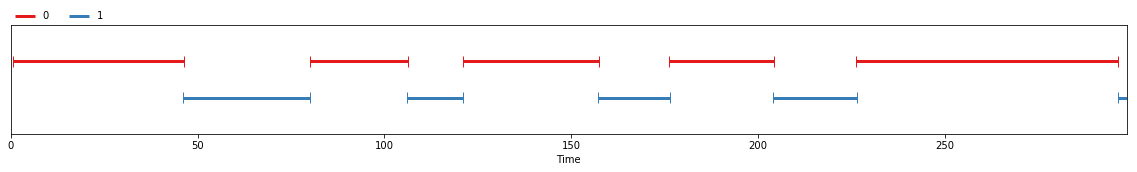

In [26]:
reference

In [27]:
from pyannote.metrics.diarization import DiarizationErrorRate
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(reference, hypothesis_lium, uem=Segment(0, 299.513))))

DER = 0.032
